In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import *
import numpy as np
from keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/drive/folders/1tTYmeHspNsESUe5-qOBjwLeodyVSxPb9?usp=sharing -O ~/dataset --folder

Retrieving folder list
Processing file 11lcXmCAhzu89eClIIlD2P42ehuLoDSKP complaints_processed.csv
Processing file 1z_K5OcQsPdediNK_ikli3ea1sjMHvpzo final-dataset-v2.csv
Processing file 1HyF-lkrRwRleSkoxtmBkIXRudgXz1W-i final-dataset.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=11lcXmCAhzu89eClIIlD2P42ehuLoDSKP
To: /root/dataset/complaints_processed.csv
100% 99.5M/99.5M [00:00<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z_K5OcQsPdediNK_ikli3ea1sjMHvpzo
To: /root/dataset/final-dataset-v2.csv
100% 97.1M/97.1M [00:00<00:00, 98.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HyF-lkrRwRleSkoxtmBkIXRudgXz1W-i
To: /root/dataset/final-dataset.csv
100% 97.1M/97.1M [00:00<00:00, 169MB/s]
Download completed


In [ ]:
!ls

 sample_data  'view?usp=drive_link'  'view?usp=sharing'


In [ ]:
data = pd.read_csv('~/dataset/complaints_processed.csv', encoding='utf8', header=None, names=['id', 'product', 'narrative'])

In [ ]:
data.head()

,id,product,narrative
0,NaN,product,narrative
1,0.0,credit_card,purchase order day shipping amount receive pro...
2,1.0,credit_card,forwarded message date tue subject please inve...
3,2.0,retail_banking,forwarded message cc sent friday pdt subject f...
4,3.0,credit_reporting,payment history missing credit report speciali...


In [ ]:
# Removendo valores none
data = data.dropna()

In [ ]:
data.head()

,id,product,narrative
1,0.0,credit_card,purchase order day shipping amount receive pro...
2,1.0,credit_card,forwarded message date tue subject please inve...
3,2.0,retail_banking,forwarded message cc sent friday pdt subject f...
4,3.0,credit_reporting,payment history missing credit report speciali...
5,4.0,credit_reporting,payment history missing credit report made mis...


In [ ]:
# passando categorias de string para numeros
product_labels = data['product'].unique()

In [ ]:
#Criando nova coluna para passar as classes de string para int
data['y_target_label'] = data['product']

product_label_classes = {}
for index, label in enumerate(list(product_labels)):
    product_label_classes[label] = index

y_target_labels = []
for product in data['product']:
    y_target_labels.append(product_label_classes[product])

data['y_target_label'] = y_target_labels

In [ ]:
# objetos para tratar texto
stemmer = PorterStemmer()
contents_tokenized = np.array([])
stop_words = stopwords.words('english')

In [ ]:
def stem(words):
    return [stemmer.stem(word.lower()) for word in words if word.isalpha()]

In [ ]:
def remove_stop_words(words):
    return [word for word in words if word not in stop_words]

In [ ]:
def tokenize(text_content):
    text_tokens = nltk.word_tokenize(text_content)
    text_without_stop_words = remove_stop_words(text_tokens)
    stemmed_words = stem(text_without_stop_words)
    return stemmed_words

In [ ]:
def vectorizer(texts):
    vectorizer = TfidfVectorizer()  # Create an instance of TfidfVectorizer
    # Fit the vectorizer to the text data and transform the text into a TF-IDF matrix
    vectorizer.fit_transform(texts)
    return vectorizer.get_feature_names_out().tolist()

In [ ]:
# texto com as strings tratadas
text = data.loc[:, ['narrative']].applymap(
    tokenize).applymap(vectorizer)['narrative'].values

In [ ]:
# Categorias correspondentes aos textos de exemplo
categories = data['y_target_label'].values

In [ ]:
# Dividindo os dados em treino e teste
train_text, test_text, train_labels, test_labels = train_test_split(
    text, categories, test_size=0.2)

In [ ]:
# Pré-processamento dos textos
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_text)

In [ ]:
sequencias_train = tokenizer.texts_to_sequences(train_text)
sequencias_test = tokenizer.texts_to_sequences(test_text)

In [ ]:
# Tamanho máximo das sequências
max_sequence_length_train = max([len(seq) for seq in sequencias_train])
sequencias_train = pad_sequences(
    sequencias_train, maxlen=max_sequence_length_train)

max_sequence_length_test = max([len(seq) for seq in sequencias_test])
sequencias_test = pad_sequences(
    sequencias_test, maxlen=max_sequence_length_test)

In [ ]:
dense_size = len(tf.keras.utils.to_categorical(categories)[0])
vocabulary = len(tokenizer.word_index) + 1

In [ ]:
# Criação do modelo de rede neural
model = Sequential()
model.add(Embedding(vocabulary, 128))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.2))
model.add(Dense(dense_size, activation='softmax'))

In [ ]:
# Compilação do modelo
optimizer = Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Treinando o modelo
model.fit(sequencias_train, train_labels, validation_data=(
    sequencias_test, test_labels), epochs=10, batch_size=64)

Epoch 1/10
2031/2031 [==============================] - 168s 82ms/step - loss: 1.0529 - accuracy: 0.6051 - val_loss: 0.8117 - val_accuracy: 0.7256
Epoch 2/10
2031/2031 [==============================] - 161s 79ms/step - loss: 0.6558 - accuracy: 0.7895 - val_loss: 0.5556 - val_accuracy: 0.8293
Epoch 3/10
2031/2031 [==============================] - 165s 81ms/step - loss: 0.4999 - accuracy: 0.8394 - val_loss: 0.4747 - val_accuracy: 0.8434
Epoch 4/10
2031/2031 [==============================] - 158s 78ms/step - loss: 0.4434 - accuracy: 0.8517 - val_loss: 0.4385 - val_accuracy: 0.8505
Epoch 5/10
2031/2031 [==============================] - 164s 81ms/step - loss: 0.4163 - accuracy: 0.8585 - val_loss: 0.4222 - val_accuracy: 0.8544
Epoch 6/10
2031/2031 [==============================] - 174s 86ms/step - loss: 0.3998 - accuracy: 0.8630 - val_loss: 0.4170 - val_accuracy: 0.8530
Epoch 7/10
2031/2031 [==============================] - 165s 81ms/step - loss: 0.3891 - accuracy: 0.8667 - val_loss: 0

In [ ]:
# Avaliando o modelo
score, acc = model.evaluate(sequencias_test, test_labels, batch_size=32)
print(f"Acurácia do modelo: {acc:.2f}")

1016/1016 [==============================] - 9s 9ms/step - loss: 0.3980 - accuracy: 0.8633
Acurácia do modelo: 0.86


1016/1016 [==============================] - 10s 10ms/step


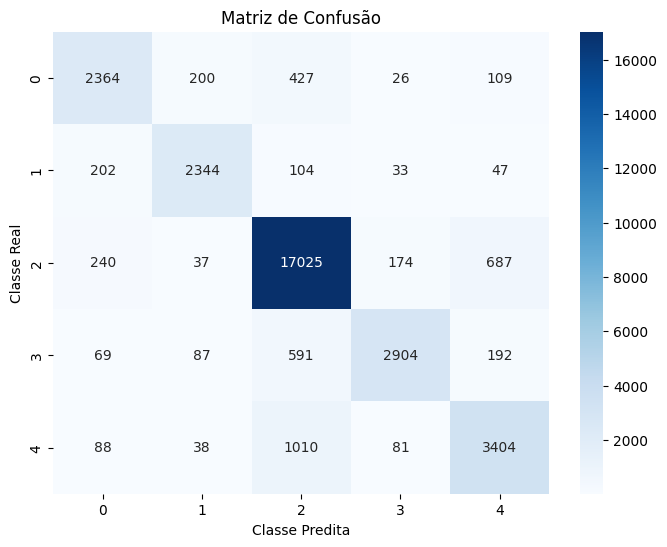

In [ ]:
# Matriz de confusao
predictions = model.predict(
    sequencias_test).argmax(axis=1)  # matriz de confusão não conseguem lidar com uma combinação de rótulos de classe multiclasse, adicionando axis=1
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.show()